In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
flights = pd.read_csv('data/flights.csv')

In [3]:
flights.head(5)

,MONTH,DAY,WEEKDAY,AIRLINE,ORG_AIR,DEST_AIR,SCHED_DEP,DEP_DELAY,AIR_TIME,DIST,SCHED_ARR,ARR_DELAY,DIVERTED,CANCELLED
0,1,1,4,WN,LAX,SLC,1625,58.0,94.0,590,1905,65.0,0,0
1,1,1,4,UA,DEN,IAD,823,7.0,154.0,1452,1333,-13.0,0,0
2,1,1,4,MQ,DFW,VPS,1305,36.0,85.0,641,1453,35.0,0,0
3,1,1,4,AA,DFW,DCA,1555,7.0,126.0,1192,1935,-7.0,0,0
4,1,1,4,WN,LAX,MCI,1720,48.0,166.0,1363,2225,39.0,0,0


#### get data about, delayed, cancelled, diverted and ontime

In [4]:
flights['DELAYED'] = flights['ARR_DELAY'].ge(15).astype(int)

In [5]:
cols = ['DIVERTED', 'CANCELLED', 'DELAYED']

In [6]:
flights['ON_TIME'] = 1 - flights[cols].any(axis=1)

In [7]:
cols.append('ON_TIME')

In [8]:
flights[cols]

,DIVERTED,CANCELLED,DELAYED,ON_TIME
0,0,0,1,0
1,0,0,0,1
2,0,0,1,0
3,0,0,0,1
4,0,0,1,0
...,...,...,...,...
58487,0,0,0,1
58488,0,0,0,1
58489,0,0,0,1
58490,0,0,1,0


In [9]:
flights[cols].sum()

DIVERTED       137
CANCELLED      881
DELAYED      11685
ON_TIME      45789
dtype: int64

In [10]:
flights.index

RangeIndex(start=0, stop=58492, step=1)

In [11]:
(flights.index.max() + 1) == flights[cols].sum().sum()

True

In [12]:
status = flights[cols].sum()

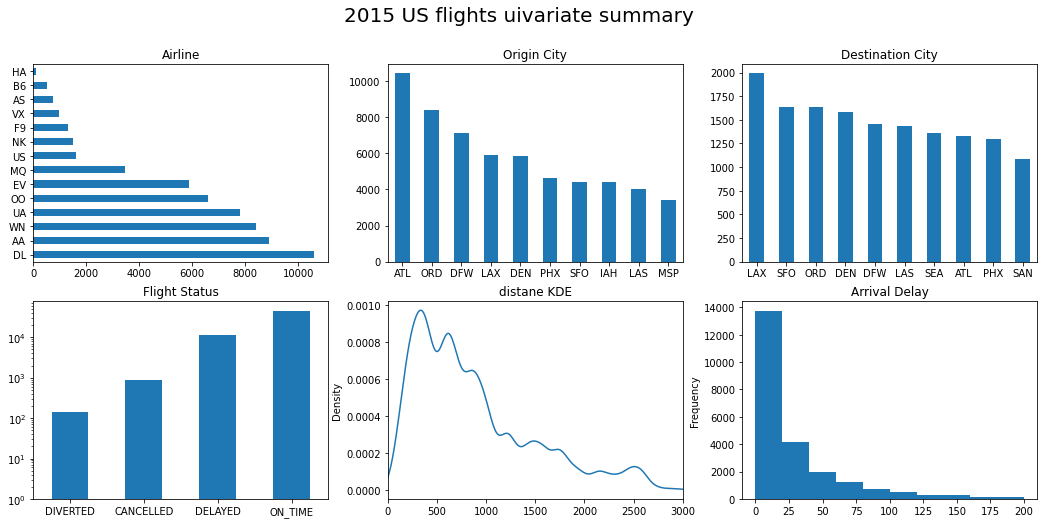

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
(ax1, ax2, ax3) = axes[0]
(ax4, ax5, ax6) = axes[1]
fig.suptitle('2015 US flights uivariate summary', size=20)

ac = flights['AIRLINE'].value_counts()
plt1 = ac.plot(kind='barh', ax=ax1, title='Airline')

oc = flights['ORG_AIR'].value_counts()
plt2 = oc.plot(kind='bar', ax=ax2, rot=0, title='Origin City')

dc = flights['DEST_AIR'].value_counts().head(10)
plt3 = dc.plot(kind='bar', ax=ax3, rot=0, title='Destination City')

plt4 = status.plot(kind='bar', ax=ax4, rot=0, log=True, title='Flight Status')

plt5 = flights['DIST'].plot(kind='kde', ax=ax5, xlim=(0, 3000), title='distane KDE')

plt6 = flights['ARR_DELAY'].plot(kind='hist', ax=ax6, title='Arrival Delay', range=(0, 200))


#### creating timestamp column for the filghts dataset , for timeseries data plotting

In [14]:
flights['SCHED_DEP'].head(10)

0    1625
1     823
2    1305
3    1555
4    1720
5    1450
6    1250
7    1020
8    1845
9     925
Name: SCHED_DEP, dtype: int64

In [15]:
hour = flights['SCHED_DEP'] // 100
minute = flights['SCHED_DEP'] % 100

In [16]:
df_date = flights[['MONTH', 'DAY']].assign(YEAR=2015, HOUR=hour, MINUTE=minute)

In [17]:
df_date

,MONTH,DAY,YEAR,HOUR,MINUTE
0,1,1,2015,16,25
1,1,1,2015,8,23
2,1,1,2015,13,5
3,1,1,2015,15,55
4,1,1,2015,17,20
...,...,...,...,...,...
58487,12,31,2015,5,15
58488,12,31,2015,19,10
58489,12,31,2015,18,46
58490,12,31,2015,5,25


In [18]:
flights_dep = pd.to_datetime(df_date)   # converts to Timestamp index

In [19]:
flights_dep.head()

0   2015-01-01 16:25:00
1   2015-01-01 08:23:00
2   2015-01-01 13:05:00
3   2015-01-01 15:55:00
4   2015-01-01 17:20:00
dtype: datetime64[ns]

In [20]:
flights.index = flights_dep

In [21]:
fc = flights.resample('W').size()   # getting weekly count

In [22]:
fc.head(5)

2015-01-04     666
2015-01-11    1088
2015-01-18    1120
2015-01-25    1169
2015-02-01    1103
Freq: W-SUN, dtype: int64

<AxesSubplot:title={'center':'Flights per Week'}>

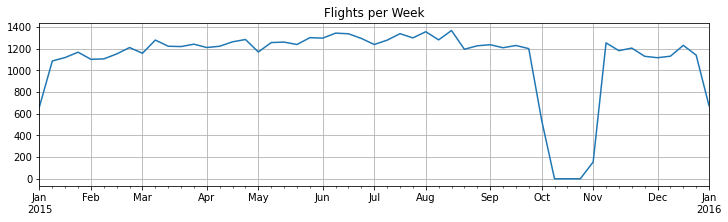

In [23]:
fc.plot(figsize=(12,3), title='Flights per Week', grid=True)  # data missing during oct - nov

In [24]:
fc_miss = fc.where(fc > 1000)

In [25]:
fc_intp = fc_miss.interpolate(limit_direction='both')

Text(0.8, 0.77, 'missing data')

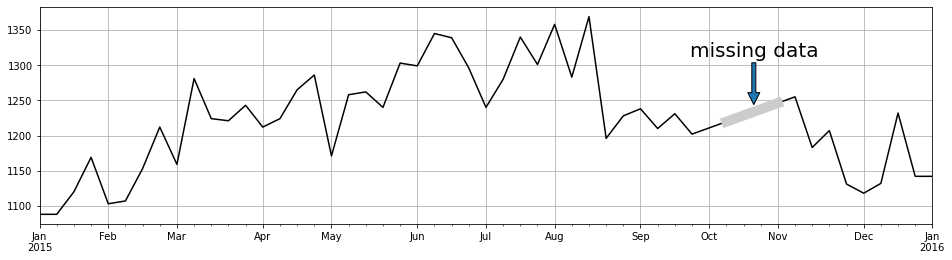

In [26]:
ax = fc_intp.plot(color='black', figsize=(16,4))

# with more width, one more line will show where the data is missing.
fc_intp[fc < 500].plot(linewidth=10, grid=True, color='.8', ax=ax)

ax.annotate(xy=(.8, .55), xytext=(.8, .77), 
            xycoords='axes fraction', text='missing data', 
            ha='center', size=20, arrowprops=dict())

### Plotting data for 10 airports that :
#### 1) Have the longest average distance traveled for inbound flights
#### 2) Have a minimum of 100 total flights:

In [27]:
data= flights.groupby('DEST_AIR')['DIST'] \
            .agg(['mean', 'count']) \
            .query('count > 100') \
            .sort_values('mean') \
            .tail(10)

In [28]:
data.head(7)

,mean,count
DEST_AIR,,
FLL,1261.114875,679
PHL,1324.490153,914
MIA,1349.589552,670
IAD,1564.146865,606
BOS,1631.797669,944
EWR,1668.000000,921
SJU,1859.436090,133


<AxesSubplot:title={'center':'Average Distance per Destination'}, xlabel='DEST_AIR'>

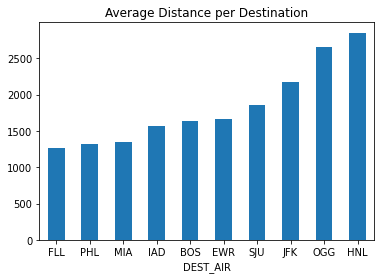

In [29]:
data.plot(kind='bar', y='mean', rot=0, legend=False, title='Average Distance per Destination')

#### plotting the correlation between DIST and the AIR_TIME

In [30]:
fs = flights.reset_index(drop=True)[['DIST', 'AIR_TIME']] \
            .query('DIST <= 2000') \
            .dropna()

In [31]:
fs.head(7)

,DIST,AIR_TIME
0,590,94.0
1,1452,154.0
2,641,85.0
3,1192,126.0
4,1363,166.0
5,1303,178.0
6,447,64.0


<AxesSubplot:xlabel='DIST', ylabel='AIR_TIME'>

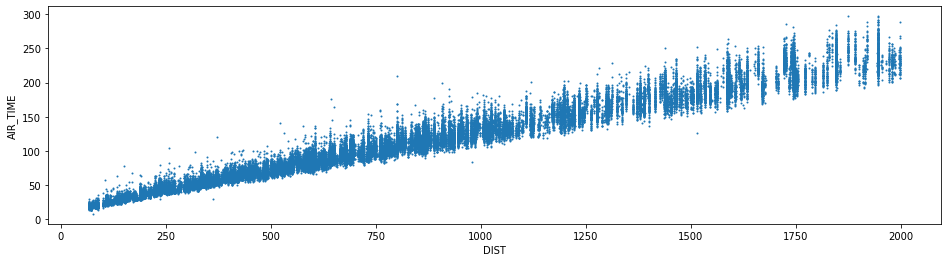

In [32]:
fs.plot(kind='scatter', x='DIST', y='AIR_TIME', s=1, figsize=(16, 4))

In [33]:
fs['DIST'].min(), fs['DIST'].max()

(67, 1999)

In [34]:
fs['DIST_GROUP'] = pd.cut(fs['DIST'], bins=range(0, 2001, 250))

In [35]:
fs['DIST_GROUP'].value_counts().sort_index()

(0, 250]         6529
(250, 500]      12631
(500, 750]      11506
(750, 1000]      8832
(1000, 1250]     5071
(1250, 1500]     3198
(1500, 1750]     3885
(1750, 2000]     1815
Name: DIST_GROUP, dtype: int64

In [36]:
normalize = lambda value: (value - value.mean()) / value.std()

In [37]:
fs.head(10)

,DIST,AIR_TIME,DIST_GROUP
0,590,94.0,"(500, 750]"
1,1452,154.0,"(1250, 1500]"
2,641,85.0,"(500, 750]"
3,1192,126.0,"(1000, 1250]"
4,1363,166.0,"(1250, 1500]"
5,1303,178.0,"(1250, 1500]"
6,447,64.0,"(250, 500]"
7,651,91.0,"(500, 750]"
8,258,44.0,"(250, 500]"
9,1608,215.0,"(1500, 1750]"


In [38]:
fs['TIME_SCORE'] = fs.groupby('DIST_GROUP')['AIR_TIME'].transform(normalize)

In [39]:
fs.head(10)

,DIST,AIR_TIME,DIST_GROUP,TIME_SCORE
0,590,94.0,"(500, 750]",0.490966
1,1452,154.0,"(1250, 1500]",-1.267551
2,641,85.0,"(500, 750]",-0.296749
3,1192,126.0,"(1000, 1250]",-1.211020
4,1363,166.0,"(1250, 1500]",-0.521999
5,1303,178.0,"(1250, 1500]",0.223553
6,447,64.0,"(250, 500]",0.639752
7,651,91.0,"(500, 750]",0.228394
8,258,44.0,"(250, 500]",-1.466326
9,1608,215.0,"(1500, 1750]",0.508643


Text(0.5, 0.98, '')

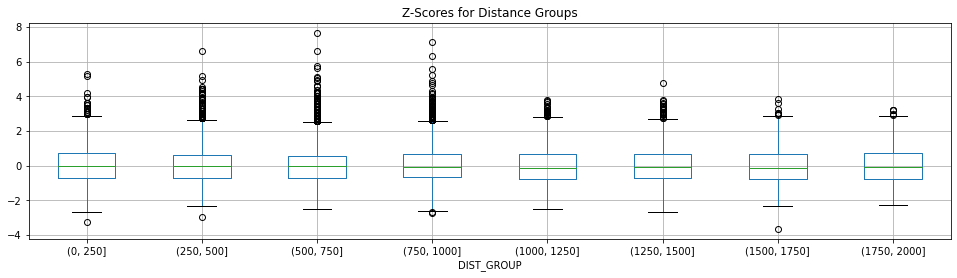

In [40]:
ax = fs.boxplot(by='DIST_GROUP', column='TIME_SCORE', figsize = (16,4))
ax.set_title('Z-Scores for Distance Groups')
ax.figure.suptitle('')

#### plotting the outliers from the above data

In [41]:
fs.sort_values('TIME_SCORE').tail(10)

,DIST,AIR_TIME,DIST_GROUP,TIME_SCORE
35564,991,185.0,"(750, 1000]",5.216009
8662,236,79.0,"(0, 250]",5.280413
22285,925,190.0,"(750, 1000]",5.602977
57164,738,153.0,"(500, 750]",5.654878
50167,731,154.0,"(500, 750]",5.742402
24698,907,199.0,"(750, 1000]",6.299519
54821,651,164.0,"(500, 750]",6.617641
16429,373,121.0,"(250, 500]",6.642075
57614,802,210.0,"(750, 1000]",7.150847
44676,643,176.0,"(500, 750]",7.667928


In [42]:
index_gt_6 = fs[fs['TIME_SCORE'] >6 ].index

In [43]:
index_gt_6

Int64Index([16429, 24698, 44676, 54821, 57614], dtype='int64')

In [44]:
outliers = flights.iloc[index_gt_6]

In [45]:
outliers.head(3)

,MONTH,DAY,WEEKDAY,AIRLINE,ORG_AIR,DEST_AIR,SCHED_DEP,DEP_DELAY,AIR_TIME,DIST,SCHED_ARR,ARR_DELAY,DIVERTED,CANCELLED,DELAYED,ON_TIME
2015-04-08 09:40:00,4,8,3,DL,ATL,CVG,940,-2.0,121.0,373,1100,54.0,0,0,1,0
2015-05-25 16:30:00,5,25,1,F9,MSP,ATL,1630,-6.0,199.0,907,1955,79.0,0,0,1,0
2015-09-10 20:00:00,9,10,4,UA,IAH,MCI,2000,-2.0,176.0,643,2201,76.0,0,0,1,0


In [46]:
outliers = outliers[['AIRLINE','ORG_AIR', 
                     'DEST_AIR', 'AIR_TIME',
                     'DIST', 'ARR_DELAY', 'DIVERTED']]

In [47]:
outliers['PLOT_NUM'] = range(1, len(outliers) + 1)

In [48]:
outliers

,AIRLINE,ORG_AIR,DEST_AIR,AIR_TIME,DIST,ARR_DELAY,DIVERTED,PLOT_NUM
2015-04-08 09:40:00,DL,ATL,CVG,121.0,373,54.0,0,1
2015-05-25 16:30:00,F9,MSP,ATL,199.0,907,79.0,0,2
2015-09-10 20:00:00,UA,IAH,MCI,176.0,643,76.0,0,3
2015-12-10 19:53:00,OO,PHX,SFO,164.0,651,146.0,0,4
2015-12-26 09:15:00,NK,ORD,DFW,210.0,802,98.0,0,5


Text(0.5, 1.0, 'Flight Time vs Distance with Outliers')

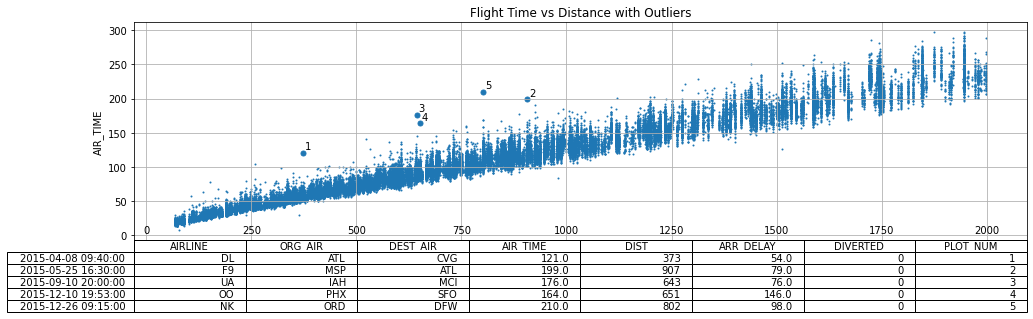

In [54]:
ax = fs.plot(x='DIST', y='AIR_TIME',
             kind='scatter', s=1,
             figsize=(16,4), table=outliers)

# on same axes, plot the outliers
outliers.plot(x='DIST', y='AIR_TIME',
              kind='scatter', s=25,
              ax=ax, grid=True)

# Marking each outlier with number and highlighting
outs = outliers[['AIR_TIME', 'DIST', 'PLOT_NUM']]

for t, d, n in outs.itertuples(index=False):
    ax.text(d + 5, t + 5, str(n))

# to remove the overlap of plot and the table below.
plt.setp(ax.get_xticklabels(), y=.1)
plt.setp(ax.get_xticklines(), visible=False)
ax.set_xlabel('')
ax.set_title('Flight Time vs Distance with Outliers')